In [11]:
import time
import argparse
import random
import os
import warnings
from importlib import import_module
import cv2


warnings.filterwarnings('ignore')

import torch
import numpy as np
from tqdm import tqdm

from datasets.data_loader import setup_loader
from datasets.data_loader import CustomDataLoader2, CustomDataLoader3
from config import Config
import matplotlib.pyplot as plt

In [12]:
config = Config(
    lr=0.0001,
    epochs=20,
    batch_size=8,
    seed=21,
    eval=False,
    augmentation='CustomAugmentation8',
    criterion='cross_entropy',
    optimizer='adam',
    model='unetmnv2',
    continue_load='',
    eval_load='',
    dataset_path='../input/data')

pytorch version: 1.6.0
GPU 사용 가능 여부: True
Tesla P40
1
Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617


,Categories,Number of annotations
0,Backgroud,NaN
1,UNKNOWN,128.0
2,General trash,2225.0
3,Paper,7448.0
4,Paper pack,527.0
5,Metal,449.0
6,Glass,488.0
7,Plastic,2472.0
8,Styrofoam,1074.0
9,Plastic bag,6114.0


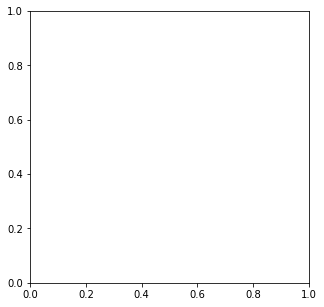

In [13]:
# print(config)
#
print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))

print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

device = "cuda" if torch.cuda.is_available() else "cpu"  # GPU 사용 가능 여부에 따라 device 정보 저장

sorted_df = setup_loader(config)

# train.json / validation.json / test.json 디렉토리 설정
train_path = config.dataset_path + '/train.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

In [14]:
augmentation_module = getattr(import_module("transforms.Augmentations"), config.augmentation)
train_transform = augmentation_module(mode='train')
train_dataset = CustomDataLoader3(data_dir=train_path, sorted_df=sorted_df, mode='train', transform=train_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=config.batch_size,
                                          num_workers=2,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.58s)
creating index...
index created!


Start extracting..
([{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0003.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 0}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0005.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0006.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0007.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 3}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0010.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 4}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0011.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 5}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0012.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 6}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0013.jpg', 'height': 5

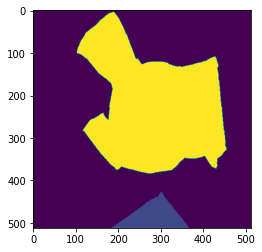

In [15]:

print('Start extracting..')
for images, masks, informs, cocoImgs in iter(train_loader):
    images = torch.stack(images)  # (batch, channel, height, width)
    masks = torch.stack(masks).long()  # (batch, channel, height, width)
    B = images.shape[0]
    print(cocoImgs)
    for i in range(B):
        image = images[i]
        mask = masks[i]
        inform = informs[i]
        cocoImg = cocoImgs[i]
        plt.imshow(mask)
        print(image.shape)
        print(mask.shape)
        print(inform)
        print(cocoImg)
        break
    break

([{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0003.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 0}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0005.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0006.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0007.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 3}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0010.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 4}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0011.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 5}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0012.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 6}], [{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0013.jpg', 'height': 512, 'width': 512, '

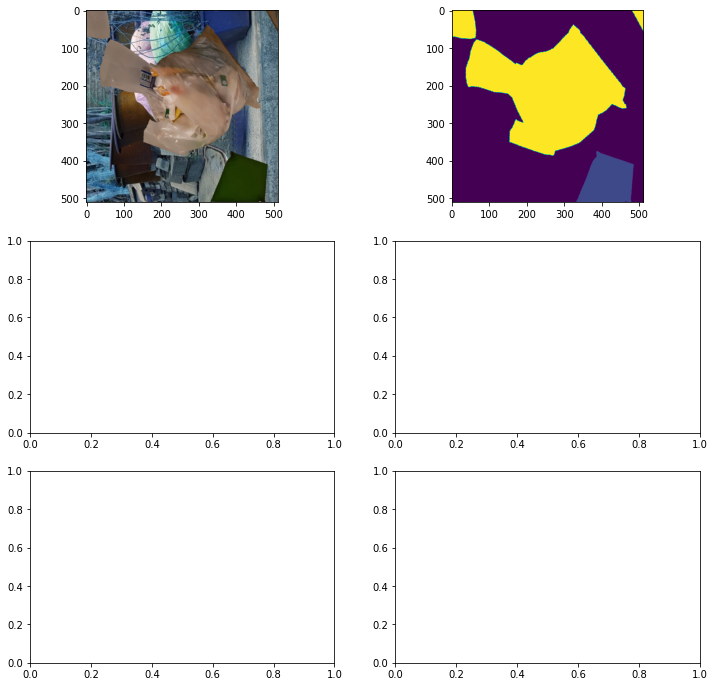

In [18]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms


for images, masks, informs, cocoImgs in iter(train_loader):
    images = torch.stack(images)  # (batch, channel, height, width)
    masks = torch.stack(masks).long()  # (batch, channel, height, width)
    B = images.shape[0]
    print(cocoImgs)
    for i in range(B):
        image = images[i]
        mask = masks[i]
        inform = informs[i]
        cocoImg = cocoImgs[i]
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
        ax1.imshow(image.permute([1, 2, 0]))
        ax2.imshow(mask)

        # cv2 를 활용하여 image 불러오기
        background = cv2.imread(os.path.join('../input/data', 'backgrounds_sample', 'background_1001_inpainted.jpg'))
        background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)

        # ax3.imshow(background)
        # ax4.imshow(mask)

        # object_transform = A.Compose([
        #         A.CropNonEmptyMaskIfExists(height=256, width=256, p=0.5),
        #         A.Resize(height=512, width=512, p=1.0),
        #         A.CLAHE(p=0.5),
        #         A.HorizontalFlip(p=1),
        #         A.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246),
        #                     max_pixel_value=255.0, p=1.0),
        #         ToTensorV2(transpose_mask=True)
        #     ])

        # transformed = train_transform(image=image.numpy(),mask=mask.numpy())
        # print(transformed)
        # image_transformed = transformed["image"]
        # mask_transformed = transformed["mask"]

        # ax5.imshow(image_transformed.permute([1,2,0]))
        # ax6.imshow(mask_transformed)

        print(image.shape)
        print(mask.shape)
        print(inform)
        print(cocoImg)
        # background = ToTensorV2()(image=background)['image']
        # print(background.size())
        # other_background = torch.where(mask>0, image, background)
        # ax5.imshow(other_background.permute([1,2,0]))

        plt.show()
        break
    break
